# Dimensionality Reduction, part 2

<a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons Licence" style="width=50" src="https://licensebuttons.net/l/by-nc-sa/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

**Authors**: Dr Matteo Degiacomi (matteo.t.degiacomi@durham.ac.uk) and Dr Antonia Mey (antonia.mey@ed.ac.uk)

**Learning Objectives**:
* Calculating and interpreting the PCA of one or multiple molecular dynamics trajectory
* Calculating TICA of a molecular dynamics trajectory

**Jupyter cheat sheet**:
* to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
* to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;

## Google Colab package installs

This installs the necessary packages for Google Colab. Please only run these if you are using Colab.

In [ ]:
# NBVAL_SKIP
!if [ -n "$COLAB_GPU" ]; then pip install condacolab; fi
import condacolab
condacolab.install()

In [ ]:
# NBVAL_SKIP
import condacolab
condacolab.check()
!mamba install -c conda-forge mdanalysis mdanalysistests mdanalysisdata nglview scikit-learn

In [ ]:
# NBVAL_SKIP
# enable third party jupyter widgets
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# NBVAL_SKIP
# copy over data repository
!if [ -n "$COLAB_GPU" ]; then git clone https://github.com/CCPBioSim/MDAnalysis_ML_workshop; fi
!if [ -n "$COLAB_GPU" ]; then cp -r MDAnalysis_ML_workshop/ML/data .; fi
!if [ -n "$COLAB_GPU" ]; then cp -r MDAnalysis_ML_workshop/ML/tica .; fi

To get started with this tutorial, let's importing some packages.

In [4]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import nglview as nv

import MDAnalysis as mda

import warnings
warnings.filterwarnings("ignore")

## 1. Introduction

The simulations in this tutorial are presented in: [M.T. Degiacomi (2019). Coupling Molecular Dynamics and Deep Learning to Mine Protein Conformational Space, Structure](https://doi.org/10.1016/j.str.2019.03.018).

MurD is a 47-kDa ATP-driven ligase responsible for the biosynthesis of a bacterial peptidoglycan precursor (UDP-N-acetylmuramoyl-L-alanyl-D-glutamate). When bound to its ligand, UDP-N-acetylmuramoyl-L-alanyl-D-alanine, MurD is stabilized in a closed conformation (PDB: [3UAG](https://www.rcsb.org/structure/3UAG)). Here, we will load a downsampled version of an MD trajectory of this state (140 ns with a step size of 0.2 ns of backbone atoms of residues 7-436).

In [5]:
folder = "data/" # this is the path where the three simulations are located

In [6]:
universe_closed = mda.Universe(f'{folder}MurD_closed_backbone.pdb')
w = nv.show_mdanalysis(universe_closed)
w

NGLWidget(max_frame=699)

In the absence of UDP-N-acetylmuramoyl-L-alanyl-D-alanine, MurD takes instead an open conformation (PDB: [1E0D](https://www.rcsb.org/structure/1E0D)). Let's load an MD trajectory of this state (same atoms selection, simulation length, and step as above).

In [7]:
universe_open = mda.Universe(f'{folder}MurD_open_backbone.pdb')
w = nv.show_mdanalysis(universe_open)
w

NGLWidget(max_frame=699)

## 2. Setup of feature extraction tools

The class `Featurizer` implements different ways of extracting features from a simulation using MDAnalysis. It is implemented to ensure consistency in feature extraction across the different datasets in the remainder of this exercises. Run this cell as-is.

In [9]:
from MDAnalysis.analysis.dihedrals import Ramachandran
from MDAnalysis.analysis import distances

class Featurizer(object):
    
    def __init__(self, feature):
        '''Featurizer class for extracting MD features with MDAnalysis
        Parameters:
        -----------
        feature : String
            name of feature
        '''
        if feature == "ramachandran":
            self.get_features = self._get_features_ramachandran
        elif feature == "distance matrix":    
            self.get_features = self._get_features_distance_matrix
        elif feature == "coordinates":    
            self.get_features = self._get_features_coordinates
        elif feature == "custom":
            self.get_features = self._get_features_custom
        else:
            raise Exception("Features extraction method %s not recognised"%feature)
            
        self.feature = feature
 
    
    def _get_features_coordinates(self, universe):
        '''
        alpha carbons coordinates
        '''
        crds = []
        ca = universe.select_atoms("name CA")
        for ts in universe.trajectory:
            crds.append(ca.positions.flatten())

        return np.array(crds)


    def _get_features_ramachandran(self, universe):
        '''
        dihedral angles
        '''
        r = Ramachandran(universe.select_atoms('protein')).run()
        r_sin = np.sin(np.deg2rad(r.angles))
        r_cos = np.cos(np.deg2rad(r.angles))
        
        r_sin = r_sin.reshape((r_sin.shape[0], np.prod(r_sin.shape[1:])))
        r_cos = r_cos.reshape((r_cos.shape[0], np.prod(r_cos.shape[1:])))
        return np.concatenate((r_sin, r_cos), axis=1)
        
    
    def _get_features_distance_matrix(self, universe):
        '''
        returns the distance matrix of each conformation (lower diagonal, flattened)
        see MDAnalysis.analysis.distances.self_distance_array
        '''
        pass

    def _get_features_custom(self, universe):
        pass

## 3. Preparation and analysis of training set

We are now ready to collect features from two independent simulations of the closed and open state of MurD. Let's start by defining which kind of feature we are interested in extracting from the simulation.

In [11]:
feature_type = "coordinates"
F = Featurizer(feature_type)

We will now extract the features from the simulations of closed and open state. This may take some time.

In [12]:
# extract features from the simulations of the closed state
feat_closed = F.get_features(universe_closed)
print(f'closed state: {feat_closed.shape[0]} conformations, {feat_closed.shape[1]} features')

# extract features from the simulation of the open state
feat_open = F.get_features(universe_open)
print(f'open state: {feat_open.shape[0]} conformations, {feat_open.shape[1]} features')

closed state: 700 conformations, 1290 features
open state: 700 conformations, 1290 features


## 4. PCA of multiple MD simulations 

Let's project our features on a lower dimensional space using Principal Components Analysis ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)), c.f. our [previous notebook on dimensionality reduction](2_DR_part2.ipynb).

In [13]:
from sklearn.decomposition import PCA

pca_closed = PCA()
pca_closed.fit(feat_closed)
proj_closed = pca_closed.transform(feat_closed)

pca_open = PCA()
pca_open.fit(feat_open)
proj_open = pca_open.transform(feat_open)

The features have now been projected in their eigenspace. The first dimension in the eigenspace is the one displaying the largest variance in data (i.e. describes the largest correlated motion in our simulation), the second dimension is ortogonal to the first and describes the second largest correlated motion, and so on. Let's have a look at how much motion is captured by each of the first 20 dimensions.

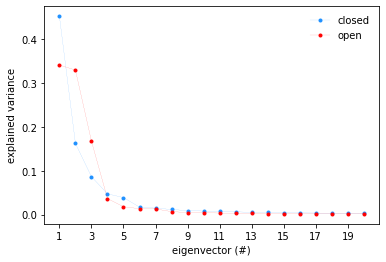

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xaxis = list(range(1, 21))
ax.plot(xaxis, pca_closed.explained_variance_ratio_[:20], marker=".", linewidth = 0.1, color="dodgerblue", label="closed")
ax.plot(xaxis, pca_open.explained_variance_ratio_[:20], marker=".", linewidth = 0.1, color="red", label="open")
ax.set_xticks(xaxis[::2])
ax.set_xlabel("eigenvector (#)")
ax.set_ylabel("explained variance")
ax.legend(frameon=False);

<div class="alert alert-info">
<b>Compressing an MD simulation</b>

Often the first few dimensions in the eigenspace of atomic coordinates can, together, capture majority of the variance in an MD simulation. How come the thousands of features describing a protein can be compressed in so few dimensions? This is because the many atoms composing a protein tend to move together, i.e. the data features very high correlation.
</div>

Let's plot a projection of the data in 2D space (the two first principal components), also reporting the percentage of variance represented by each component.

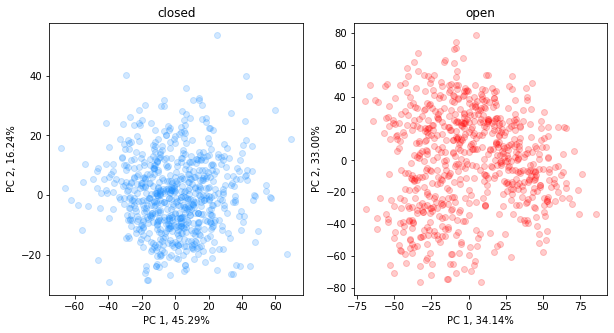

In [15]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(proj_closed[:, 0], proj_closed[:, 1], alpha=0.2, color="dodgerblue")
ax1.set_title("closed")
ax1.set_xlabel(f'PC 1, {pca_closed.explained_variance_ratio_[0]*100:3.2f}%')
ax1.set_ylabel(f'PC 2, {pca_closed.explained_variance_ratio_[1]*100:3.2f}%')

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(proj_open[:, 0], proj_open[:, 1], alpha=0.2, color="red")
ax2.set_title("open")
ax2.set_xlabel(f'PC 1, {pca_open.explained_variance_ratio_[0]*100:3.2f}%')
ax2.set_ylabel(f'PC 2, {pca_open.explained_variance_ratio_[1]*100:3.2f}%');

The issue we are having, is that each dataset has been projected in its own eigenspace. In other terms, the two plots we have just produced just report on the structure of their dataset, but are not directly comparable. Do compare two simulations, we need to project them in the ***same*** eigenspace. This requires concatenating the trajectories (of course, this can only be done if the same features have been extracted from them).

In [16]:
#concatenate the two trajectories
all_features = np.concatenate((feat_closed, feat_open))

# calculate PCA and project the individual trajectories in the resulting eigenspace
pca = PCA()
pca.fit(all_features)

proj_closed = pca.transform(feat_closed)
proj_open = pca.transform(feat_open)

Now, let's plot the PCA of our concatenated simulations.

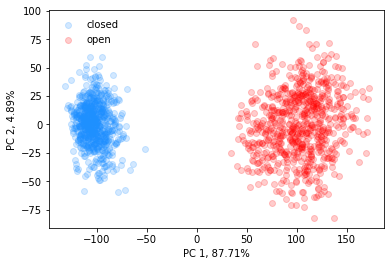

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(proj_closed[:, 0], proj_closed[:, 1], alpha=0.2, color="dodgerblue", label="closed")
ax.scatter(proj_open[:, 0], proj_open[:, 1], alpha=0.2, color="red", label="open")
ax.set_xlabel(f'PC 1, {pca.explained_variance_ratio_[0]*100:3.2f}%')
ax.set_ylabel(f'PC 2, {pca.explained_variance_ratio_[1]*100:3.2f}%')
ax.legend(frameon=False);

<div class="alert alert-success">
<b>Task 1.</b> What happens if you downsample one of the two simulations, before concatenating them?</div>

<details>
<summary> <mark> Answer 1</mark> </summary>

We can create an unbalanced dataset featuring a simulation with way less conformations than the other (20 times less) as follows:

```Python  
all_features = np.concatenate((feat_closed[::20], feat_open))
```

The resulting projection into a 2D eigenspace will look different from that obtained from a balanced dataset. The simulation having the larger number of conformations will become more relevant (i.e. will "spread more" in the eigenspace).
</details>


<div class="alert alert-warning">
<b>Watch out for rototranslations!</b>

If the features you are extracting are affected by the specific position and orientation of the molecule in the simulation box (e.g., you are extracting atomic coordinates), it is commonplace to first align your trajectory. The PCA will otherwise identify rototranslation as more important variations than any internal motion you may be interested in. Some features are unaffected by rototranslation of the dataset (e.g. dihedral angles), in this case trajectory alignment is not necessary.
</div>

<div class="alert alert-success">
<b>Task 2.</b> In Section 2 we have defined the class <code>Featurizer</code>, defining different methods to extract features from an MDAnalysis Universe. The class was used in the first cell of Section 3. Run again this notebook from Section 3, setting  <code>feature_type = "ramachandran"</code>. What do you notice?</div>

<div class="alert alert-success">
<b>Task 3.</b> Return to Section 2 and, within the class <code>Featurizer</code>, use MDAnalysis to implement the method <code>_get_features_distance_matrix</code>, returning a flattened lower triangular distance matrix. Rerun the rest of the notebook with your new feature. If you are feeling adventurous, implement your own feature in the function <code>Featurizer._get_features_custom</code></div>

<details>
<summary> <mark> Answer 3</mark> </summary>

The following is the method to be implemented in Featurizer.
    
```Python    
def _get_features_distance_matrix(self, universe):
    '''
    returns distance matrix of each conformation (lower diagonal, flattened)
    '''
    crds = []
    ca = universe.select_atoms("name CA")
    for ts in universe.trajectory:
        crds.append(distances.self_distance_array(ca.positions))

    return np.array(crds)
```
    
As new feature, how about mesuring the angles formed by different domains? Or their relative orientation in spherical coordinates? Or selecting the distances between specific amino acid pairs, instead of using the whole distance matrix?
</details>


## 4. tICA of multiple MD simulations

We will use the same simulation datasets as before, but this time we will perform a tICA analysis. Like for the PCA, we will start by analysing the simulations separately.

In [18]:
from tica.tica import tICA

tic_closed = tICA()
tic_closed.fit([feat_closed])
tic_proj_closed = tic_closed.transform([feat_closed])[0]

tic_open = tICA()
tic_open.fit([feat_open])
tic_proj_open = tic_open.transform([feat_open])[0]

We will now plot 2D projections of the two simulations in their respective tIC space. Here, we will colour each datapoint as a function of its timestep (from yellow to purple).

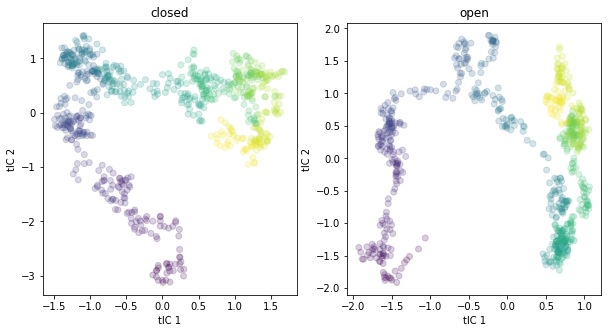

In [21]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(tic_proj_closed[:, 0], tic_proj_closed[:, 1], alpha=0.2, c=range(len(tic_proj_closed)))#, color="dodgerblue")
ax1.set_title("closed")
ax1.set_xlabel(f'tIC 1')
ax1.set_ylabel(f'tIC 2')

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(tic_proj_open[:, 0], tic_proj_open[:, 1], alpha=0.2, c=range(len(tic_proj_open)))#, color="red")
ax2.set_title("open");
ax2.set_xlabel(f'tIC 1')
ax2.set_ylabel(f'tIC 2');

As we noticed when discussing PCA, two simulations can only be compared if they are projected in the same space. Let's do the same for tICA!

In [23]:
tic = tICA()
tic.fit([feat_closed, feat_open])

tic_proj_closed2 = tic.transform([feat_closed])[0]
tic_proj_open2 = tic.transform([feat_open])[0]

Time to plot the projections of the two simulations in their shared tIC space now.

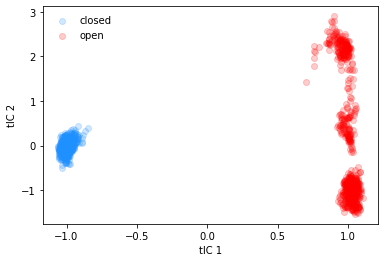

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tic_proj_closed2[:, 0], tic_proj_closed2[:, 1], alpha=0.2, color="dodgerblue", label="closed")
ax.scatter(tic_proj_open2[:, 0], tic_proj_open2[:, 1], alpha=0.2, color="red", label="open")
ax.legend(frameon=False);
ax.set_xlabel(f'tIC 1')
ax.set_ylabel(f'tIC 2');

<div class="alert alert-success">
<b>Task 4.</b> Looking at both the projection of the two simulations in separated and shared tIC space, how does the tICA analysis differ from PCA using different input features?</div>

## 5. Conclusions

<div class="alert alert-info">
<b>Key points:</b>
    
- PCA identifies dominant motions in MD simulations by looking at directions of maximal variance in data
- tICA identifies dimensions whereby the decay time of the autocorrelation function of each dimension is maximised
- some features are position-dependent (e.g. atom coordinates), and some are not (e.g. dihedral angles)
- if handling position-dependent features:
    - trajectory alignment will affect what kind of motion will be identified by any dimensionality reduction technique
    - if the trajectory is not aligned, the dominant motion identified will be most likely linked to the rigid body rototranslation of the molecule of interest
- when the features are highly correlated, data can be efficiently compressed in a low-dimensional space with minimal information loss.
</div>

In these first two notebook we have mentioned three common dimensionality reduction techniques: PCA, tICA, and t-SNE (for the latter, see [previous notebook](1_DR_part1.ipynb)). Other techniques exist though! For instance, the MurD simulations we used in this notebook have also be examined using a special type of neural network called autoencoder:
[V.K. Ramaswamy et al. (2021). Learning protein conformational space with convolutions and latent interpolations, Physical Review X 11](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.011052)

### Next Notebook

[Clustering](3_clustering.ipynb)